In [1]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def fetch_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

def preprocess_data(data):
    data.index = pd.to_datetime(data.index)
    ts = data['Close']
    return ts

def forecast_with_arima(ts, order, forecast_periods):
    model = ARIMA(ts, order=order)
    fitted_model = model.fit()
    forecast = fitted_model.forecast(forecast_periods)
    plt.figure(figsize=(10, 6))
    plt.plot(ts, label="Historical")
    plt.plot(forecast, label="ARIMA Forecast", color="orange")
    plt.title("ARIMA Forecast")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()
    return forecast

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def prepare_lstm_data(ts, sequence_length):
    scaler = MinMaxScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1, 1))
    
    data = []
    for i in range(len(ts_scaled) - sequence_length):
        data.append(ts_scaled[i:i + sequence_length])
    
    data = np.array(data)
    X, y = data[:, :-1], data[:, -1]
    return train_test_split(X, y, test_size=0.2, shuffle=False), scaler

def train_lstm_model(X_train, y_train, input_size=1, hidden_size=50, num_layers=1, epochs=50, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    
    return model

def forecast_with_lstm(model, X_test, scaler):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        predictions = model(X_test).cpu().numpy()
    
    predictions = scaler.inverse_transform(predictions)
    return predictions



[*********************100%***********************]  1 of 1 completed
/home/void/allinfo_new/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/void/allinfo_new/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/void/allinfo_new/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/void/allinfo_new/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index i

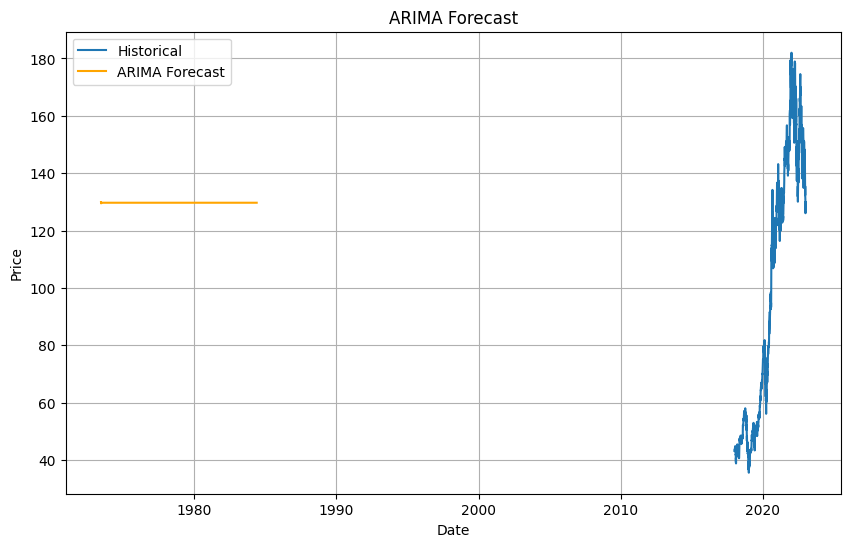

/home/void/allinfo_new/venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([967, 1])) that is different to the input size (torch.Size([967])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/50], Loss: 0.1264
Epoch [20/50], Loss: 0.0825
Epoch [30/50], Loss: 0.0818
Epoch [40/50], Loss: 0.0786
Epoch [50/50], Loss: 0.0786


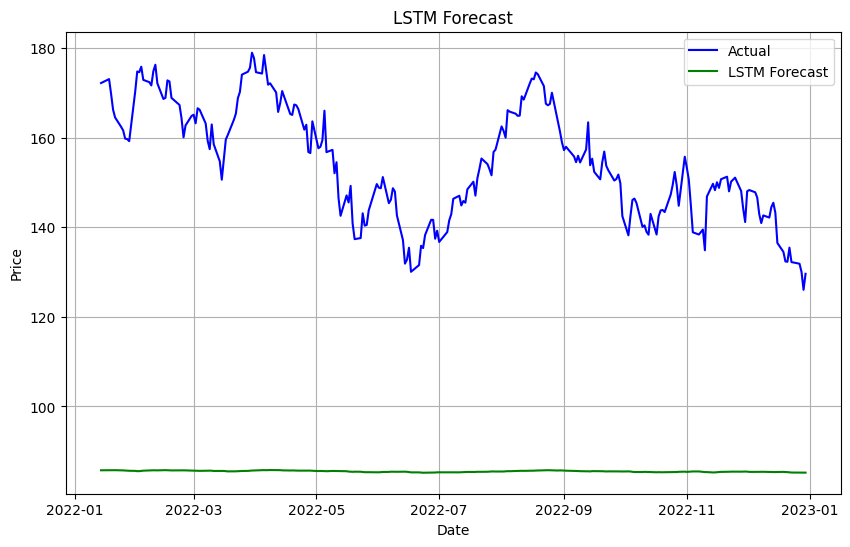

In [4]:
TICKER = "AAPL"
START_DATE = "2018-01-01"
END_DATE = "2023-01-01"
ARIMA_ORDER = (5, 1, 0)
FORECAST_PERIODS = 4000
SEQUENCE_LENGTH = 50
EPOCHS = 50
LR = 0.001

# Step 1: Fetch Data
data = fetch_data(TICKER, START_DATE, END_DATE)

# Step 2: Preprocess Data
ts = preprocess_data(data)

# Step 3: ARIMA Forecasting
arima_forecast = forecast_with_arima(ts, ARIMA_ORDER, FORECAST_PERIODS)

# Step 4: LSTM Forecasting
(X_train, X_test, y_train, y_test), scaler = prepare_lstm_data(ts, SEQUENCE_LENGTH)
lstm_model = train_lstm_model(X_train, y_train, epochs=EPOCHS, lr=LR)
lstm_forecast = forecast_with_lstm(lstm_model, X_test, scaler)

# Plot LSTM Forecast
plt.figure(figsize=(10, 6))
plt.plot(ts.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual", color="blue")
plt.plot(ts.index[-len(y_test):], lstm_forecast, label="LSTM Forecast", color="green")
plt.title("LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()
